In [1]:
import tensorflow as tf
tf.__version__

'2.10.0'

In [2]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np


from IPython import display

In [19]:
#Wczytanie zdjęć treningowych 

people = []

size = 70

for j in range(27,41):

    images_train = []

    for i in range(1,size+1):
        im = Image.open(r"C:\Users\jankowiaka\Documents\python\mag\project\Baza_zdjec_konwersja_64x64\s"+str(j)+'\\'+str(i)+'.png')
        arr_im = np.array(im)
        arr_im = (arr_im - 127.5) / 127.5  # Normalize the images to [-1, 1]
        images_train.append(arr_im)
    people.append(images_train)

print(len(images_train))
print(len(people))

70
14


In [4]:
BUFFER_SIZE = 70
BATCH_SIZE = 16


generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

EPOCHS = 20000
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])


In [5]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(16*16*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((16, 16, 256)))
    
    assert model.output_shape == (None, 16, 16, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    #assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    #assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    #assert model.output_shape == (None, 64, 64, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 1)

    return model

In [6]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[64, 64, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))


    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [7]:
generator = make_generator_model()
discriminator = make_discriminator_model()

In [8]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [9]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [10]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [11]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [12]:
def new_init(generator, discriminator):
    
    generator = make_generator_model()
    discriminator = make_discriminator_model()

    return generator, discriminator

In [13]:
def print_generator(model, epoch, numb, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig(f'./GAN_Models/Models/'+str(numb)+'/image_at_epoch_{:04d}.png'.format(epoch+1))
  plt.show()

In [14]:
def train(images, epochs):

  for i in range(len(images)):

    print(i)

    #global generator
    #global discriminator

    #global generator_optimizer 
    #global discriminator_optimizer 

    #generator_optimizer = tf.keras.optimizers.Adam(1e-4)
    #discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

    #generator, discriminator = new_init(generator, discriminator)

    dataset = tf.data.Dataset.from_tensor_slices(images[i]).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

    for epoch in range(epochs):

      for image_batch in dataset:
        train_step(image_batch)

      if (epoch + 1) % 500 == 0:
        print(f'Epoka: {epoch + 1}')

      if (epoch + 1) % 5000 == 0:
        # Produce images for the GIF as you go
        display.clear_output(wait=True)

        generator.save(f'./GAN_Models/Models/'+str(i+10)+'/generator_model_epoch_'+str(epoch+1)+'.h5')
        discriminator.save(f'./GAN_Models/Models/'+str(i+10)+'/discriminator_model_epoch_'+str(epoch+1)+'.h5')
        print_generator(generator, epoch, i, seed)
        print(f'Modele zapisane po {epoch + 1} epokach.')


In [ ]:


# Usuń zliczanie czasu
# Może restart kompa?


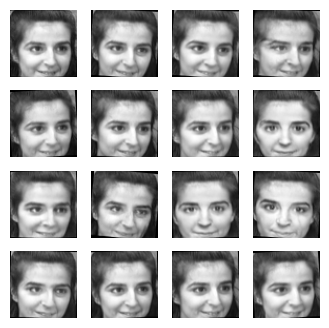

Modele zapisane po 20000 epokach.
Time for epoch 20000 is 1.523134708404541 sec


In [15]:
train(people, EPOCHS)

In [16]:


seed = tf.random.normal([20, noise_dim])

In [17]:
def generate_and_save_images(model_path, num_images, save_path=None):
    
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    # Wczytywanie zapisanego modelu
    model = tf.keras.models.load_model(model_path)
    
    # Generowanie losowych wektorów latentnych
    noise = tf.random.normal([num_images, 100])
    
    
    # Generowanie obrazów
    generated_images = model(noise, training=False)
    
    # Normalizacja obrazów z [-1, 1] do [0, 1]
    generated_images = (generated_images + 1) / 2.0
    
    # Tworzenie wykresu dla wygenerowanych obrazów
    fig, axs = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
    for i in range(num_images):
        axs[i].imshow(generated_images[i, :, :, 0], cmap='gray')
        axs[i].axis('off')
        
        if save_path:
            img = Image.fromarray((generated_images[i, :, :, 0] * 255).numpy().astype(np.uint8))
            img.save(f"{save_path}/generated_image_{i}.png")
    
    plt.show()

In [18]:
generate_and_save_images('./GAN_Models/Models/2/generator_model_epoch_500.h5', num_images=50, save_path="./images")

OSError: No file or directory found at ./GAN_Models/Models/2/generator_model_epoch_500.h5

In [ ]:
  # Generate after the final epoch
  #display.clear_output(wait=True)
  generate_and_save_images(generator, 100, seed)

NameError: name 'generator' is not defined